<a href="https://colab.research.google.com/github/megmarv/PsychoAI-/blob/Emotion-Identification2/custom_Model_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Input

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [2]:
# Load preprocessed data from .npy files
X_train = np.load("/content/drive/MyDrive/X_train.npy")
y_train = np.load("/content/drive/MyDrive/y_train.npy")

# Define the list of acceptable image extensions (for reference, not used here)
image_exts = ['jpeg', 'jpg', 'png']

# Function to validate and preprocess images (if needed)
def validate_and_preprocess(image):
    """
    Validate and preprocess an image (if needed).
    This function can be used to perform additional checks or transformations.
    """
    # Example: Check if the image is valid (not empty)
    if image is None or image.size == 0:
        print("Invalid image detected.")
        return None

    # Example: Convert to grayscale if not already
    if len(image.shape) == 3 and image.shape[2] == 3:  # Check if RGB
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    return image

# Iterate through the preprocessed images and labels
for i, (image, label) in enumerate(zip(X_train, y_train)):
    try:
        # Validate and preprocess the image (if needed)
        processed_image = validate_and_preprocess(image)

        if processed_image is None:
            print(f"Skipping invalid image at index {i}.")
            continue

        # Update the image in the dataset (if preprocessing was applied)
        X_train[i] = processed_image

    except Exception as e:
        # Handle any exceptions that occur during processing
        print(f"Issue with image at index {i}. Error: {e}")

# Save the updated dataset (if any changes were made)
np.save("X_train_validated.npy", X_train)
np.save("y_train_validated.npy", y_train)

print("Validation and preprocessing complete!")

Validation and preprocessing complete!


In [3]:
import os
import numpy as np
import pandas as pd

# Define a function to count the number of samples in preprocessed .npy files
def count_samples_in_npy(data_dir, set_name):
    """
    Count the number of samples in preprocessed .npy files for each class.

    Args:
        data_dir (str): Directory containing the .npy files.
        set_name (str): Name of the dataset (e.g., 'train' or 'test').

    Returns:
        pd.DataFrame: A DataFrame with the counts of samples for each class.
    """
    # Initialize an empty dictionary to hold the count of samples for each class
    counts = {}

    # Load the preprocessed data
    X = np.load(os.path.join(data_dir, f"X_{set_name}.npy"))
    y = np.load(os.path.join(data_dir, f"y_{set_name}.npy"))

    # Get unique classes and their counts
    unique_classes, class_counts = np.unique(y, return_counts=True)

    # Map class indices to class names (if you have a label encoder or class names)
    # Assuming you have a list of class names in the same order as the encoded labels
    class_names = ["anger", "happy", "sad", "neutral", "surprise", "fear", "disgust"]

    # Populate the counts dictionary
    for class_idx, count in zip(unique_classes, class_counts):
        class_name = class_names[class_idx]  # Map class index to class name
        counts[class_name] = count

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the directories containing the preprocessed .npy files
train_data_dir = '/content/drive/MyDrive' # Directory containing X_train.npy and y_train.npy
test_data_dir = '/content/drive/MyDrive'# Directory containing X_test.npy and y_test.npy

# Count the samples in the training dataset and print the result
train_count = count_samples_in_npy(train_data_dir, 'train')
print(train_count)

# Count the samples in the testing dataset and print the result
test_count = count_samples_in_npy(test_data_dir, 'test')
print(test_count)

       anger  happy   sad  neutral  surprise  fear  disgust
train   1991   1968  2019     1930      1996  1981     1986
      anger  happy  sad  neutral  surprise  fear  disgust
test    486    509  458      547       481   496      491


<Axes: >

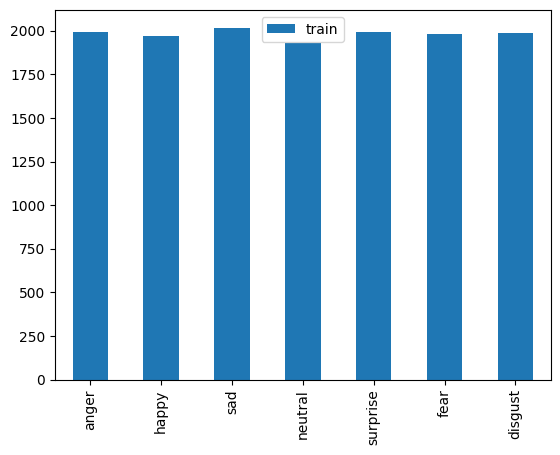

In [4]:
train_count.transpose().plot(kind='bar')

<Axes: >

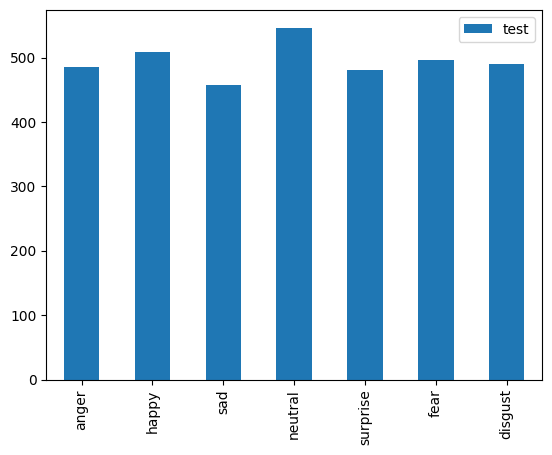

In [5]:
test_count.transpose().plot(kind='bar')

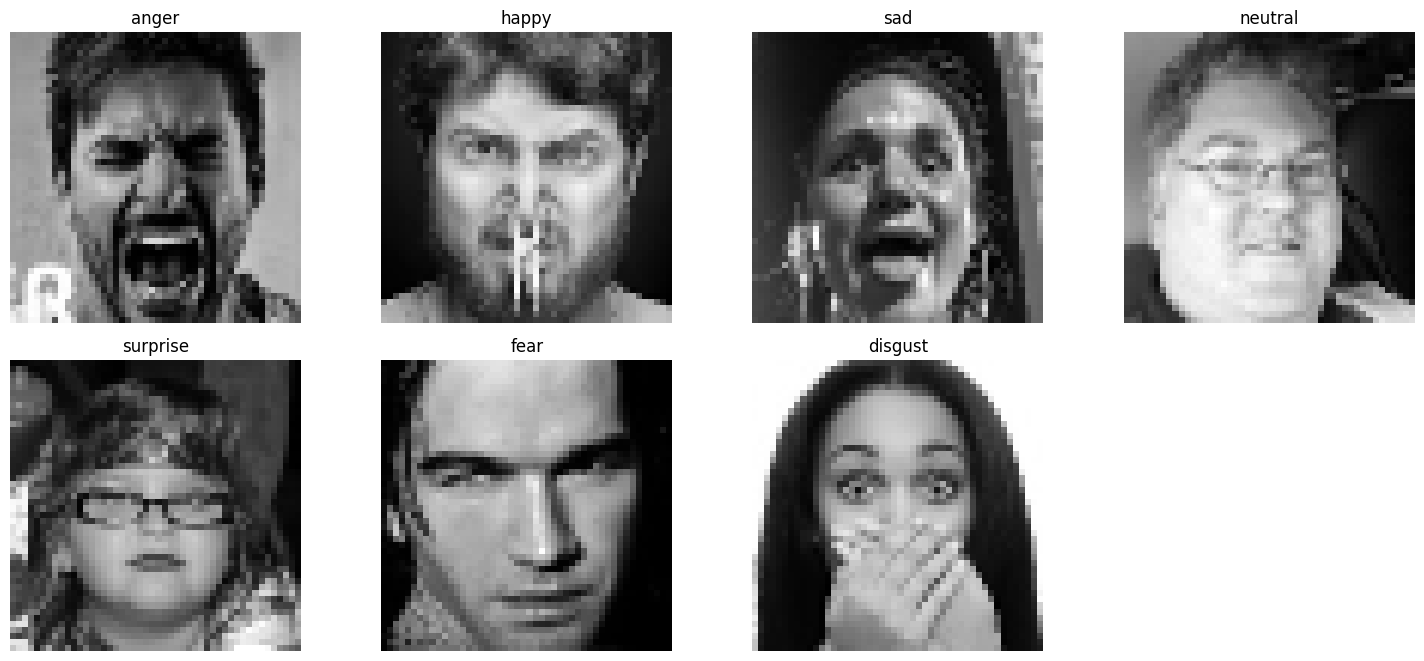

In [6]:
# Load preprocessed .npy data
train_data_dir = '/content/drive/MyDrive'
X_train = np.load(os.path.join(train_data_dir, "X_train.npy"))  # Shape: (num_samples, height, width)
y_train = np.load(os.path.join(train_data_dir, "y_train.npy"))  # Shape: (num_samples,)

# Define class names (same as used in count_samples_in_npy function)
class_names = ["anger", "happy", "sad", "neutral", "surprise", "fear", "disgust"]

# Create a figure for visualization
plt.figure(figsize=(15, 10))

# Select one random sample for each emotion
for i, class_name in enumerate(class_names, 1):
    indices = np.where(y_train == i - 1)[0]  # Get indices of samples for this class
    if len(indices) > 0:
        random_idx = np.random.choice(indices)  # Pick a random sample
        img = X_train[random_idx]  # Get image

        plt.subplot(3, 4, i)
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
# Load .npy files
train_images = np.load("/content/drive/MyDrive/X_train.npy")  # Shape: (num_samples, height, width, channels)
train_labels = np.load("/content/drive/MyDrive/y_train.npy")  # Shape: (num_samples,)

test_images = np.load("/content/drive/MyDrive/X_test.npy")
test_labels = np.load("/content/drive/MyDrive/y_test.npy")

In [13]:
# Ensure images are in the correct shape (height, width, channels)
if len(train_images.shape) == 3:  # If no channel dimension, assume grayscale and add one
    train_images = np.expand_dims(train_images, axis=-1)
    test_images = np.expand_dims(test_images, axis=-1)

# Ensure data type compatibility with ImageDataGenerator
train_images = train_images.astype(np.float32) / 255.0  # Normalize images
test_images = test_images.astype(np.float32) / 255.0

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Define ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Augmentation function
def augment(image, label):
    image = tf.numpy_function(train_datagen.random_transform, [image], tf.float32)
    return image, label

# Apply augmentation to the training dataset
train_dataset = train_dataset.map(augment).batch(32).shuffle(1000)
test_dataset = test_dataset.batch(32)  # No augmentation for test data

# Print dataset details
print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")


Train dataset: <_ShuffleDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Test dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# Defining the Model

In [16]:
input_shape = (224, 224, 3)

# Explicit input layer
input_layer = Input(shape=input_shape)

# Load base model with include_top=False
base_model = ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_layer)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Create a Sequential model and add layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Converts (7, 7, 2048) to (2048,)
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')  # Output layer for 7 classes
])

In [18]:
# Compile the model
optimizer = Adamax(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,787,207 (94.56 MB)

 Trainable params: 24,737,671 (94.37 MB)

 Non-trainable params: 49,536 (193.50 KB)